## Data Cleaning & EDA

> ###  Tanzania Census 2012 Dataset

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [354]:
tanz = pd.read_csv("../data/Tanzania_2012_en.csv")

In [355]:
tanz.info()
tanz.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60794 entries, 0 to 60793
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indicator    60794 non-null  object 
 1   Unit         60794 non-null  object 
 2   Subgroup     60794 non-null  object 
 3   Area         60794 non-null  object 
 4   Area ID      60794 non-null  object 
 5   Time Period  60794 non-null  object 
 6   Source       60794 non-null  object 
 7   Data Value   60781 non-null  float64
 8   Footnotes    56979 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.2+ MB


,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
0,Children under-5 years severely underweight,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,2.7,NaN
1,Production of cement,Tonne,Total,Mainland,TZA001,2009,MoFEA_Economic Survey (ES)_Yearly,34793.0,NaN


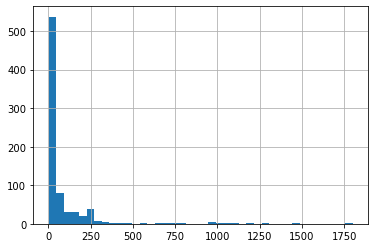

In [356]:
tanz["Indicator"].value_counts().hist(bins = 40);  #773 indicators

In [357]:
tanz["Indicator"].value_counts()[lambda x : x.values > 250]
#149 indicators with more than 100 values
#36 indicators with more than 250 values

Population size                                                  1801
Source of improved drinking water by households                  1472
Improved toilet facilities by household                          1465
Primary school net enrolment ratio                               1299
Source of non improved drinking water by households              1288
Primary school gross enrolment ratio                             1191
Households by type of refuse disposal                            1112
Non improved toilet facilities by household                      1062
Operators engage in crops                                        1021
Planted area in a crops                                           990
Quantity harvested in crops                                       990
Quantity sold in a crops                                          990
Yield in a crops                                                  990
Area harvested in crops                                           990
Pupils who sat for t

> Let's take a look at the top indicators that contain "water" 

#### Indicators with the Word "water"

In [358]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("water")].head(10)
#29 indicators with "water"

Source of improved drinking water by households                                                1472
Source of non improved drinking water by households                                            1288
Water coverage                                                                                  218
Non-revenue water (NRW) for regional centres                                                    130
Population with access to piped or protected water as their main source in regional centres     128
Households within 1 km of drinking water in dry seasons                                          63
Population served with water                                                                     62
Households within 15 minutes to water supply in dry seasons                                      27
Population using an improved drinking water source                                               20
Water demand                                                                                     20


#### Source of Improved Drinking Water by Households

> Source of improved drinking water by households for each area, divided into 8 subgroups
>
> Each subgroup is a source of improved drinking water
>
> Only for the year 2012
>
> For each Area ID, the Data Value for the subgroup "Improved" is the sum of all other subgroup 

In [359]:
improved_water = tanz["Indicator"] == "Source of improved drinking water by households"
cols_to_drop = ["Indicator", "Unit", "Footnotes", "Source", "Time Period"]
improved_water_df = tanz[improved_water].drop(columns = cols_to_drop)
#Time Period = 2012
#Unit = Percent
#Source = NBS_Population and Housing Census, 2012_2013-2018
improved_water_df.head(3)

,Subgroup,Area,Area ID,Data Value
16041,Piped Water into dwelling,Kagera,TZA001018,2.9
16042,Piped Water into dwelling,Tarime,TZA001020001,1.5
16512,Piped Water into dwelling,Mtwara,TZA001009,8.1


In [360]:
improved_water_df["Subgroup"].value_counts()
#8 subgroups, equal sizes
#actually 7 subgroups,
#the "Improved" is the sum of all 7 subgroups for each Area ID

Piped Water into dwelling    184
Piped Water to yard/plot     184
Tube well/ borehole          184
Protected dug well           184
Rain water collection        184
Public tap/ standpipe        184
Protected Spring             184
Improved                     184
Name: Subgroup, dtype: int64

In [361]:
improved_water_df[subgr_improved]["Area ID"].str.len().value_counts()
#Area ID length of 9 is for regions (total 30 of them)
#25 regions with data availabel are mainland only, no data for 5 regions of Zanzibar island,
#Area ID length of 12 is for sub-regions
#we focus on regions

12    159
9      25
Name: Area ID, dtype: int64

In [362]:
#focus on the subgroup "Improved"
subgr_improved = improved_water_df["Subgroup"]=="Improved"
#and regions
regions = improved_water_df[subgr_improved]["Area ID"].str.len()==9

improved_by_region = improved_water_df[subgr_improved & regions].drop(columns = "Subgroup")
improved_by_region = improved_by_region.sort_values(by="Data Value")
improved_by_region

,Area,Area ID,Data Value
19097,Tabora,TZA001014,27.3
19054,Mara,TZA001020,32.9
19150,Geita,TZA001025,33.7
19021,Lindi,TZA001008,35.0
19096,Singida,TZA001013,38.5
18988,Kagera,TZA001018,39.0
19095,Rukwa,TZA001015,41.8
19099,Shinyanga,TZA001017,43.2
18999,Katavi,TZA001023,44.3
19100,Tanga,TZA001004,48.0


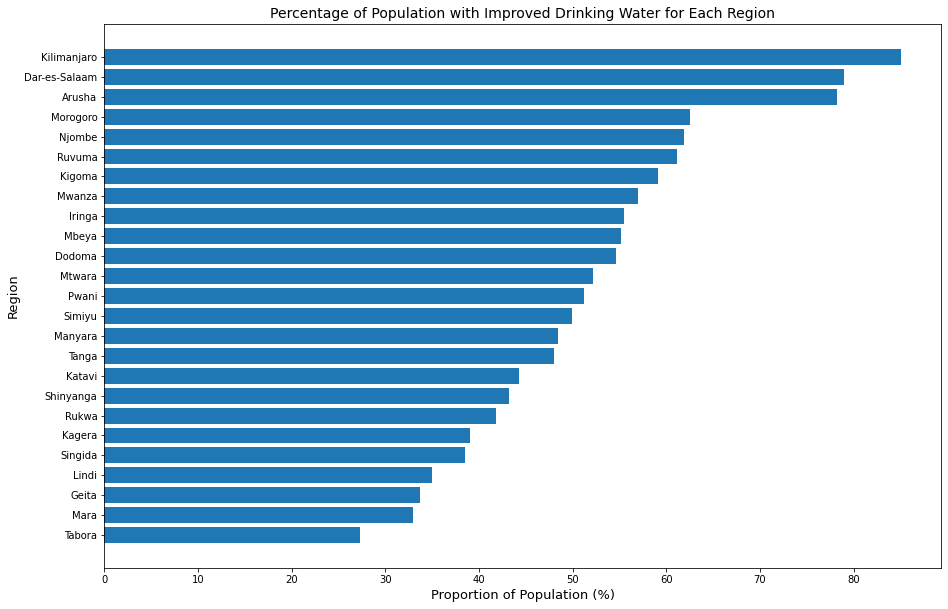

In [363]:
plt.figure(figsize=(15,10))
plt.barh(y = improved_by_region["Area"],
         width = improved_by_region["Data Value"])
plt.title("Percentage of Population with Improved Drinking Water for Each Region", fontsize=14)
plt.xlabel("Proportion of Population (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

plt.savefig('../visualizations/Improved_drinking_water_by_region', dpi=300, transparent=True, bbox_inches = 'tight');

> Overall, less than half of the population have access to improved drinking water
>
> In worst regions, only a third have access to improved drinking water

In [364]:
water_source_improved = water.loc['Source of improved drinking water by households'].sort_values(by='Area')
water_source_improved = water_source_improved[water_source_improved['Area ID']!='TZA001002006'].sort_values(by='Area')
water_source_improved = water_source_improved[water_source_improved['Area ID']!='TZA001013002'].sort_values(by='Area')
water_source_improved = water_source_improved[water_source_improved['Area ID']!='TZA001005002'].sort_values(by='Area')
water_source_improved = water_source_improved[water_source_improved['Area ID']!='TZA001025001'].sort_values(by='Area')
water_source_improved = water_source_improved[water_source_improved['Area']!='Simiyu']
water_source_improved = water_source_improved[water_source_improved['Area']!='Njombe']
water_source_improved = water_source_improved[water_source_improved['Area']!='Katavi']
water_source_improved = water_source_improved[water_source_improved['Area']!='Geita']
water_source_improved = water_source_improved[water_source_improved['Subgroup']!='Improved']
water_source_improved.head(3)   # filtering out the duplicate regions and those that aren't in the water pump dataset

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Source of improved drinking water by households,Percent,Protected Spring,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",1.6,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of improved drinking water by households,Percent,Rain water collection,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",0.3,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of improved drinking water by households,Percent,Piped Water into dwelling,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",19.9,"TZA_Population and Housing Census (PHC) 2012, ..."


In [365]:
water_source_improved_table = water_source_improved.pivot_table(values='Data Value', columns='Area', index='Subgroup')
water_source_improved_table

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Subgroup,,,,,,,,,,,,,,,,,,,,
Piped Water into dwelling,19.9,10.7,10.2,2.9,7.7,31.9,6.2,7.4,6.0,16.0,12.9,8.1,12.2,11.1,6.8,12.5,8.3,4.8,3.6,12.0
Piped Water to yard/plot,17.1,6.5,9.1,3.1,5.4,23.2,2.3,5.2,4.0,10.0,9.1,2.8,10.9,9.9,2.1,9.7,8.5,1.8,3.1,8.9
Protected Spring,1.6,0.6,1.5,11.0,13.4,1.5,0.8,1.1,2.1,2.7,0.4,0.8,1.7,0.4,3.1,3.4,0.3,0.5,0.3,1.1
Protected dug well,3.8,4.0,7.1,4.8,8.7,1.3,7.8,4.0,7.6,7.8,7.1,3.2,9.7,9.5,7.3,10.3,11.7,7.2,11.4,4.9
Public tap/ standpipe,34.2,26.7,22.7,10.9,18.8,25.3,10.0,24.5,5.4,15.0,19.7,17.5,11.7,15.0,12.4,16.0,8.7,14.1,4.6,17.3
Rain water collection,0.3,0.3,0.1,2.0,0.1,0.4,2.0,0.3,2.7,0.1,0.1,18.0,0.2,0.6,0.0,0.0,0.3,0.3,0.1,1.0
Tube well/ borehole,1.3,5.8,4.8,4.3,5.0,1.5,5.9,5.9,5.1,3.6,13.2,1.8,10.6,4.7,10.1,9.2,5.4,9.8,4.2,2.8


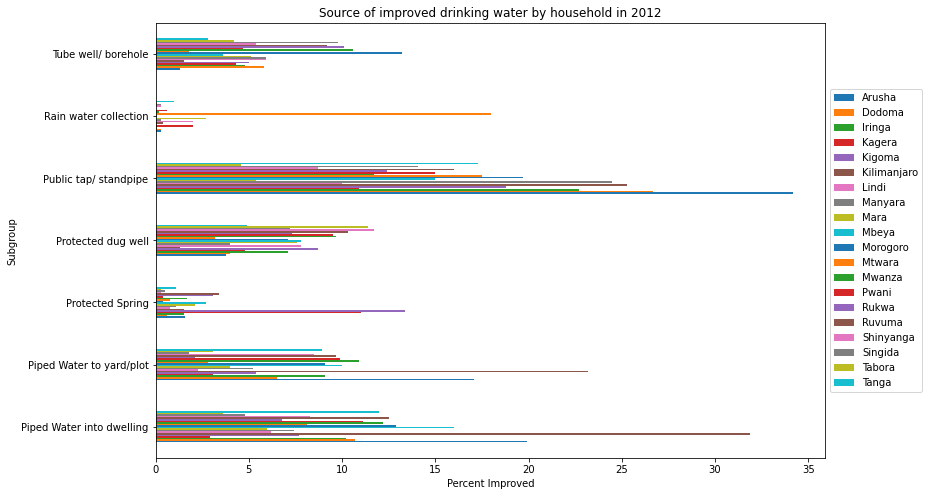

In [366]:
water_source_improved_table.plot(figsize=(12,8), kind='barh')
plt.xlabel('Percent Improved')
plt.title('Source of improved drinking water by household in 2012')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/improved_water_source.png', transparent=True, bbox_inches = 'tight');

- This is showing the sources for improved drinking water. It appears that as a whole the public tap/standpipe is the largest source, though some regions really stick out in some areas over others.

#### Source of Non Improved Drinking Water by Households

> Source of non improved drinking water by households for each area, divided into 7 subgroups
>
> Each subgroup is a source of non improved drinking water
>
> Only for the year 2012
>
> For each Area ID, the Data Value for the subgroup "Non-improved" is the sum of all other subgroup

In [367]:
non_improved_water = tanz["Indicator"] == "Source of non improved drinking water by households"
cols_to_drop = ["Indicator", "Unit", "Time Period", "Source", "Footnotes"]
non_improved_water_df = tanz[non_improved_water].drop(columns = cols_to_drop)
#Time Period = 2012
#Unit = Percent
#Source = NBS_Population and Housing Census, 2012_2013-2018
non_improved_water_df.head(3)

,Subgroup,Area,Area ID,Data Value
16589,Non-Improved,Mbulu,TZA001021003,56.2
16590,Non-Improved,Simanjiro,TZA001021004,54.8
16591,Non-Improved,Rorya,TZA001020006,89.2


In [368]:
non_improved_water_df["Subgroup"].value_counts()
#7 subgroups, equal sizes
#the Non-Improved subgroup is the sum of other 6 subrgoups

Non-Improved                           184
Unprotected dug well                   184
Unprotected Spring                     184
Bottled water                          184
Cart with small tank/drum              184
Tanker truck                           184
Surface water (river dam lake etc.)    184
Name: Subgroup, dtype: int64

In [369]:
non_improved_water_df["Area ID"].str.len().value_counts()

12    1113
9      175
Name: Area ID, dtype: int64

In [370]:
#focus on the "non-improved" subgroup and regions (Area ID with len = 9)
non_improved = non_improved_water_df["Subgroup"]=="Non-Improved"
regions = non_improved_water_df["Area ID"].str.len()==9
non_improved_by_region = non_improved_water_df[non_improved & regions].drop(columns = "Subgroup").sort_values(by="Data Value")
non_improved_by_region

,Area,Area ID,Data Value
17819,Kilimanjaro,TZA001003,15.0
17643,Dar-es-Salaam,TZA001007,21.1
17632,Arusha,TZA001002,21.8
17580,Morogoro,TZA001005,37.5
17608,Njombe,TZA001022,38.1
17609,Ruvuma,TZA001010,38.9
17676,Kigoma,TZA001016,41.2
17607,Mwanza,TZA001019,43.0
17654,Iringa,TZA001011,44.5
17558,Mbeya,TZA001012,44.8


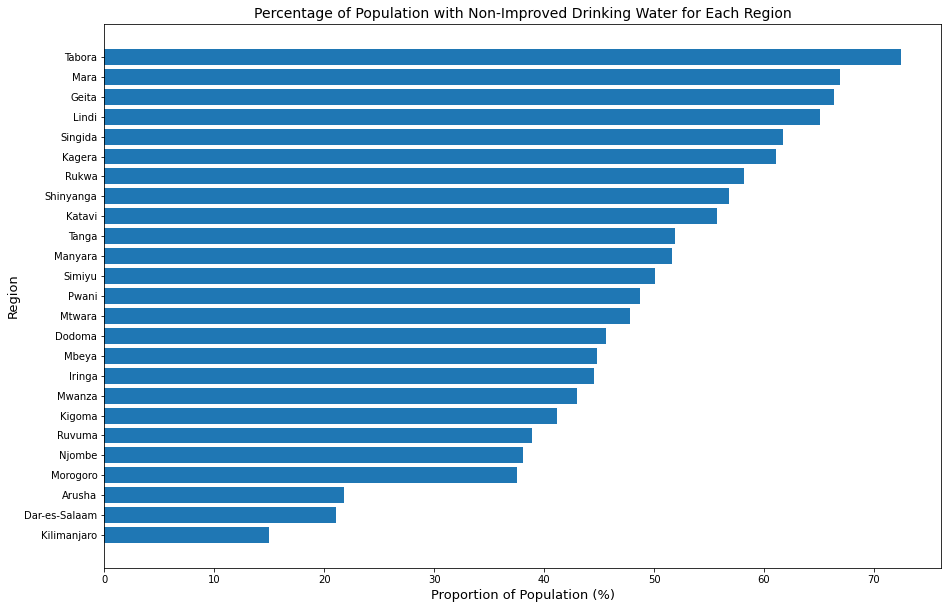

In [371]:
plt.figure(figsize=(15,10))
plt.barh(y = non_improved_by_region["Area"],
         width = non_improved_by_region["Data Value"])
# plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Percentage of Population with Non-Improved Drinking Water for Each Region", fontsize=14)
plt.xlabel("Proportion of Population (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);
#the Data Value in percent most likely means percentage of population

> This indicator complements the previous one (improved drinking water). They add up to 100% for each region.

In [372]:
water_source_non_impr = water.loc['Source of non improved drinking water by households'].sort_values(by='Area')
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area ID']!='TZA001002006'].sort_values(by='Subgroup')
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area ID']!='TZA001013002'].sort_values(by='Area')
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area ID']!='TZA001005002'].sort_values(by='Area')
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area ID']!='TZA001025001'].sort_values(by='Area')
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area']!='Simiyu']
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area']!='Njombe']
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area']!='Katavi']
water_source_non_impr = water_source_non_impr[water_source_non_impr['Area']!='Geita']
water_source_non_impr = water_source_non_impr[water_source_non_impr['Subgroup']!='Non-Improved']
water_source_non_impr.head()   # filtering out duplicate regions and regions not in water pump dataset
# also removing the 'non-improved' section due to redundancy

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Source of non improved drinking water by households,Percent,Bottled water,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",0.2,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of non improved drinking water by households,Percent,Cart with small tank/drum,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",2.4,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of non improved drinking water by households,Percent,Unprotected dug well,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",3.0,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of non improved drinking water by households,Percent,Tanker truck,Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",0.3,"TZA_Population and Housing Census (PHC) 2012, ..."
Source of non improved drinking water by households,Percent,Surface water (river dam lake etc.),Arusha,TZA001002,2012,"NBS_Population and Housing Census, 2012_2013-2018",9.0,"TZA_Population and Housing Census (PHC) 2012, ..."


In [373]:
water_source_non_impr_table = water_source_non_impr.pivot_table(values='Data Value', columns='Area', index='Subgroup')
water_source_non_impr_table

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Subgroup,,,,,,,,,,,,,,,,,,,,
Bottled water,0.2,0.2,0.1,0.2,0.1,0.1,0.2,0.3,0.3,0.1,0.1,0.3,0.2,0.1,0.1,0.1,0.2,0.1,0.1,0.2
Cart with small tank/drum,2.4,5.2,1.9,0.3,2.6,1.6,1.5,6.6,0.6,0.7,1.3,2.2,0.7,1.2,0.4,0.0,5.0,1.5,2.2,1.2
Surface water (river dam lake etc.),9.0,4.9,13.4,19.3,17.0,4.2,10.4,11.8,23.5,12.7,12.2,15.3,9.3,10.6,18.2,7.5,17.9,14.9,9.7,14.0
Tanker truck,0.3,0.3,0.1,0.1,0.2,0.2,0.6,3.4,0.3,0.1,1.0,0.3,0.1,1.3,0.1,0.0,0.2,0.1,0.1,1.8
Unprotected Spring,6.9,4.8,16.0,32.6,10.3,7.8,7.2,10.6,19.2,16.7,7.7,7.4,10.1,3.2,17.3,14.5,6.2,11.7,5.0,16.0
Unprotected dug well,3.0,30.2,13.0,8.6,11.0,1.1,45.2,18.9,23.0,14.5,15.2,22.3,22.6,32.3,22.1,16.8,27.3,33.4,55.4,18.7


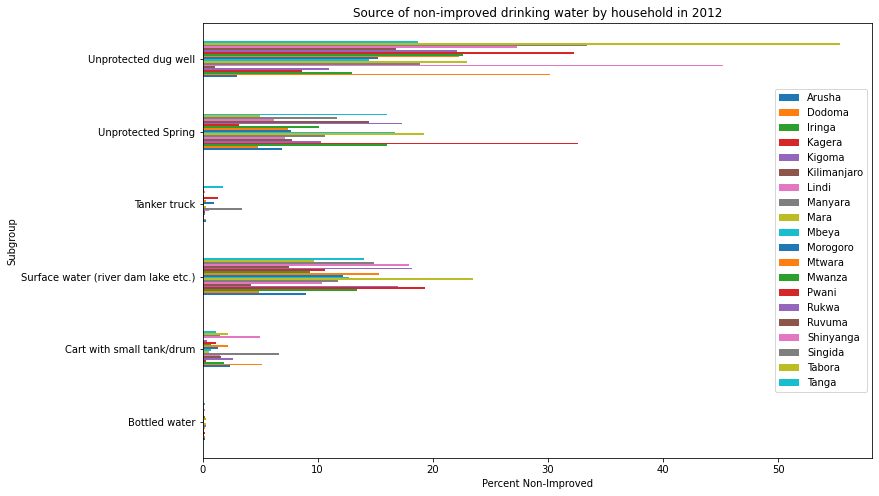

In [374]:
water_source_non_impr_table.plot(figsize=(12,8), kind='barh')
plt.xlabel('Percent Non-Improved')
plt.title('Source of non-improved drinking water by household in 2012')
plt.legend(loc='center right')
plt.savefig('../visualizations/non-improved_water_source.png', transparent=True, bbox_inches = 'tight');

- This is showing the sources of non-improved drinking water. As a whole, unprotected dug wells are the largest source.

#### Water Coverage

> Water coverage each year between 2008 and 2012 for 24 regions 
> 
> The data for each year is duplicated
>
> Most areas have 5 data points, 1 for each year
>
> What does water coverage mean in this case?

In [375]:
water_coverage_df = tanz[tanz["Indicator"] == "Water coverage"]
#Subgroup =  Rural
#Unit = percent
water_coverage_df = water_coverage_df.drop(columns = ["Indicator", "Unit", "Subgroup", "Footnotes"])
water_coverage_df.sort_values(by = "Area").head(3)

,Area,Area ID,Time Period,Source,Data Value
972,Arusha,TZA001002,2009,EWURA_Water Utilities Performance Review_Yearly,66.72
1014,Arusha,TZA001002,2009,MoWI_Rural Water Supply Database_Yearly,66.72
973,Arusha,TZA001002,2010,EWURA_Water Utilities Performance Review_Yearly,60.84


In [376]:
water_coverage_df["Area"].value_counts()

Ruvuma           10
Kilimanjaro      10
Dodoma           10
Kigoma           10
Iringa           10
Dar-es-Salaam    10
Arusha           10
Shinyanga        10
Tabora           10
Singida          10
Rukwa            10
Tanga            10
Kagera           10
Mwanza           10
Pwani            10
Mtwara           10
Morogoro         10
Mara             10
Mbeya            10
Manyara          10
Lindi            10
Njombe            4
Geita             2
Katavi            2
Name: Area, dtype: int64

In [377]:
water_coverage_df["Time Period"].value_counts()

2012    48
2010    44
2008    42
2009    42
2011    42
Name: Time Period, dtype: int64

In [378]:
water = pd.read_csv('../data/cleaned_data/tz_regions_water.csv', index_col='Indicator')
water = water.drop(columns='Unnamed: 0')
water_demand = water.loc['Water demand'].sort_values(by='Time Period')
water_demand.drop(columns='Footnotes', inplace=True)
water_demand.head(3)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Water demand,m3/yr,Urban,Arusha,TZA001002,2009-2010,MoWI/EWURA_Urban Water Supply Database- MajIs ...,19.36
Water demand,m3/yr,Urban,Shinyanga,TZA001017,2009-2010,MoWI/EWURA_Urban Water Supply Database- MajIs ...,6.19
Water demand,m3/yr,Urban,Mwanza,TZA001019,2009-2010,MoWI/EWURA_Urban Water Supply Database- MajIs ...,25.23


In [379]:
water_demand_table = water_demand.pivot_table(values='Data Value', columns='Area', index='Time Period')
water_demand_table

Area,Arusha,Mwanza,Shinyanga
Time Period,,,
2009-2010,19.36,25.23,6.19
2010-2011,19.36,37.79,6.15
2011-2012,34.04,42.95,6.64
2012-2013,34.04,40.35,6.15
2013-2014,35.37,37.79,6.57


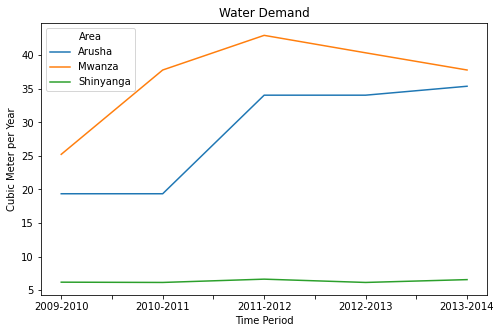

In [380]:
water_demand_table.plot(figsize=(8,5))
plt.title('Water Demand')
plt.ylabel('Cubic Meter per Year')
plt.savefig('../visualizations/water_demand.png', transparent=True, bbox_inches = 'tight');

- The above plot shows how vastly different the demand for water is in these 3 regions.

In [381]:
water_supply = water.loc['Water produced in urban water supply authority'].sort_values(by='Time Period')
water_supply.drop(columns='Footnotes', inplace=True)
water_supply.head(3)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Water produced in urban water supply authority,m3/yr,Urban,Arusha,TZA001002,2008-2009,MoWI/EWURA_Urban Water Supply Database- MajIs ...,14.42
Water produced in urban water supply authority,m3/yr,Urban,Mwanza,TZA001019,2008-2009,MoWI/EWURA_Urban Water Supply Database- MajIs ...,18.69
Water produced in urban water supply authority,m3/yr,Urban,Arusha,TZA001002,2009-2010,MoWI/EWURA_Urban Water Supply Database- MajIs ...,13.69


In [382]:
water_supply_table = water_supply.pivot_table(values='Data Value', columns='Area', index='Time Period')
water_supply_table

Area,Arusha,Mwanza
Time Period,,
2008-2009,14.42,18.69
2009-2010,13.69,21.97
2010-2011,14.18,23.59
2011-2012,13.34,22.83
2012-2013,14.13,23.06
2013-2014,14.77,25.91


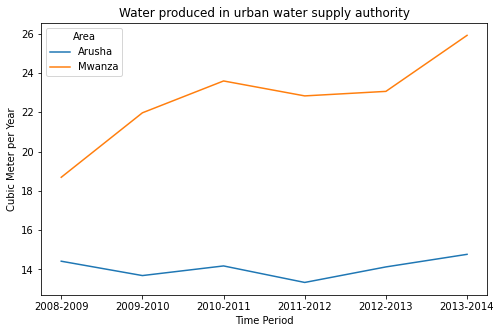

In [383]:
water_supply_table.plot(figsize=(8,5))
plt.title('Water produced in urban water supply authority')
plt.ylabel('Cubic Meter per Year')
plt.savefig('../visualizations/water_produced_in_urban_supply.png', transparent=True, bbox_inches = 'tight');

- The above plot is again showing the vast difference between the regions for the amount of water produced in urban areas.

In [384]:
water_coverage = water.loc['Water coverage'].sort_values(by='Time Period')
water_coverage = water_coverage[water_coverage['Source']=='MoWI_Rural Water Supply Database_Yearly']
water_coverage.drop(columns='Footnotes', inplace=True)
water_coverage = water_coverage[water_coverage['Area']!='Njombe']   # filtering out the regions that aren't in the
water_coverage = water_coverage[water_coverage['Area']!='Katavi']   # water pump dataset
water_coverage = water_coverage[water_coverage['Area']!='Geita']
water_coverage.head()

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Water coverage,Percent,Rural,Rukwa,TZA001015,2008,MoWI_Rural Water Supply Database_Yearly,51.1
Water coverage,Percent,Rural,Dodoma,TZA001001,2008,MoWI_Rural Water Supply Database_Yearly,65.3
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2008,MoWI_Rural Water Supply Database_Yearly,68.8
Water coverage,Percent,Rural,Tanga,TZA001004,2008,MoWI_Rural Water Supply Database_Yearly,73.9
Water coverage,Percent,Rural,Morogoro,TZA001005,2008,MoWI_Rural Water Supply Database_Yearly,66.2


In [385]:
water_coverage_table = water_coverage.pivot_table(values='Data Value', columns='Area', index='Time Period', fill_value=0)
water_coverage_table  # just making a table of the above DF

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Time Period,,,,,,,,,,,,,,,,,,,,
2008,59.600000,65.300000,70.200000,50.500000,57.700000,68.800000,54.400000,53.400000,51.10,59.600000,66.200000,70.900000,58.60000,69.100000,51.100000,56.000000,49.600000,47.400000,43.600000,73.900000
2009,66.720000,61.210000,66.830000,58.860000,62.650000,69.090000,51.010000,52.540000,54.07,61.210000,66.190000,65.060000,57.02000,65.940000,52.410000,57.730000,51.530000,49.000000,44.570000,68.900000
2010,60.840000,59.660000,65.930000,57.850000,62.280000,68.890000,40.120000,52.850000,54.70,60.040000,58.580000,67.040000,61.49000,64.800000,53.920000,57.240000,52.160000,51.360000,38.850000,65.710000
2011,58.530000,50.040000,65.820000,56.010000,60.190000,73.070000,41.380000,63.010000,51.04,60.040000,61.890000,49.400000,58.28000,64.600000,54.670000,59.910000,50.070000,50.440000,43.360000,58.230000
2012,60.663329,47.037215,64.949601,57.206598,59.621191,74.444593,37.120964,62.908008,49.00,52.685361,63.101115,45.093115,61.98289,66.082933,45.687155,58.810995,51.612049,49.886863,46.843831,59.846986


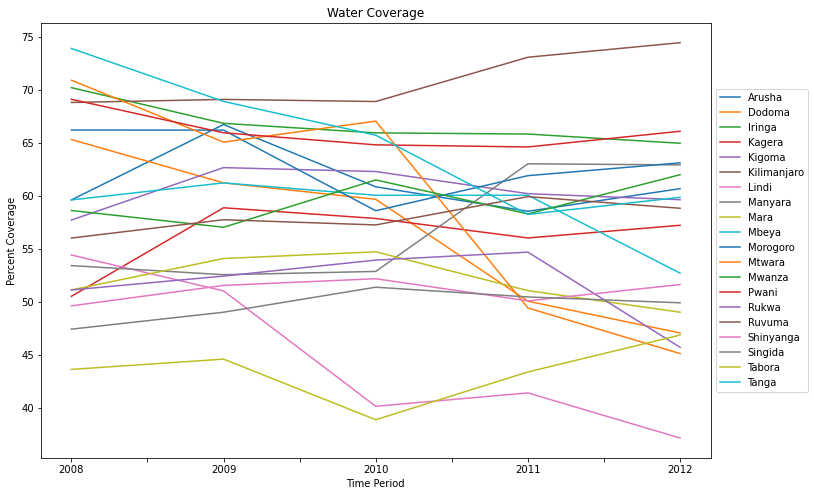

In [386]:
water_coverage_table.plot(figsize=(12,8))
plt.title('Water Coverage')
plt.ylabel('Percent Coverage')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/water_coverage.png', transparent=True, bbox_inches = 'tight');

#### Non-revenue Water (NRW) for Regional Centres

> Yearly NRW for each area over 5 years between 2010 and 2015
>
> Non-revenue water: water that has beeen produced and is "lost" before it reaches customers (leak, theft)

In [387]:
nrw = tanz["Indicator"]=="Non-revenue water (NRW) for regional centres"
cols_to_drop = ["Indicator", "Unit", "Subgroup", "Source", "Footnotes"]
#Unit = Percent
#Subgroup = Total
#Source = EWURA_Water Utilities Performance Review_Yearly
#27 areas
#5 Time Period: 2010-11, 11-12, 12-13, 13-14, 14-15
nrw_df = tanz[nrw].drop(columns = cols_to_drop)
nrw_df.sort_values(by = "Area").head(3)

,Area,Area ID,Time Period,Data Value
55521,Arusha,TZA001002,2010-2011,40.6
55522,Arusha,TZA001002,2011-2012,37.4
55523,Arusha,TZA001002,2012-2013,40.6


In [388]:
nrw_df["Time Period"].value_counts()

2012-2013    27
2011-2012    26
2013-2014    26
2014-2015    26
2010-2011    25
Name: Time Period, dtype: int64

In [389]:
#focus on newest data: Time Period = "2014-2015"
#and regions: Area ID with length = 9
#23 regions
y2014 = nrw_df["Time Period"]=="2014-2015"
regions = nrw_df["Area ID"].str.len()==9
nrw_2014_by_region = nrw_df[y2014 & regions].drop(columns=["Time Period", "Area ID"])
nrw_2014_by_region = nrw_2014_by_region.sort_values(by = "Data Value")
nrw_2014_by_region

,Area,Data Value
55510,Tanga,22.6
55505,Shinyanga,22.6
55540,Geita,23.0
55609,Kilimanjaro,24.1
55480,Ruvuma,26.9
55398,Mtwara,28.8
55520,Dodoma,29.7
55545,Kigoma,30.0
55457,Manyara,31.8
55485,Rukwa,32.7


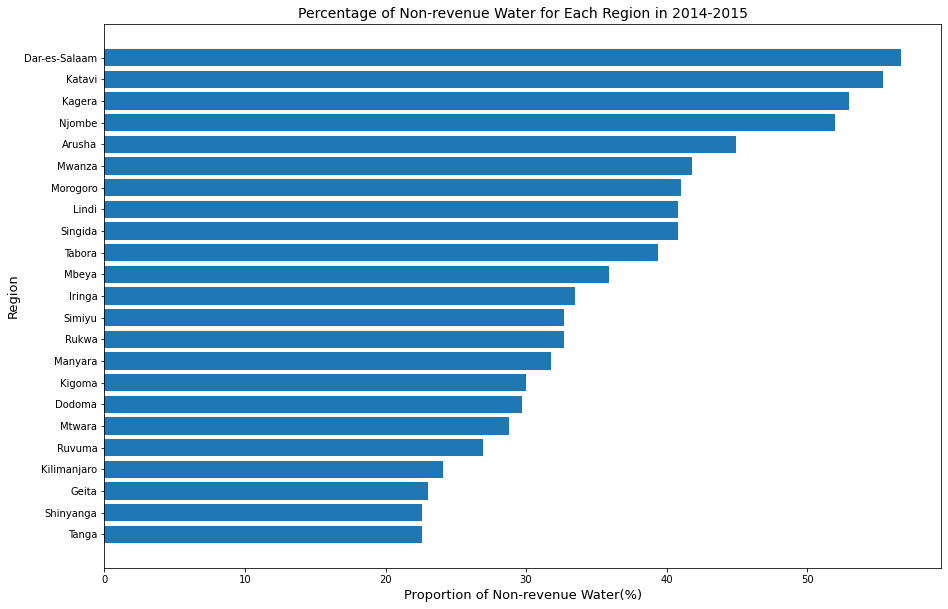

In [390]:
plt.figure(figsize=(15,10))
plt.barh(y = nrw_2014_by_region["Area"],
         width = nrw_2014_by_region["Data Value"])
plt.title("Percentage of Non-revenue Water for Each Region in 2014-2015", fontsize=14)
plt.xlabel("Proportion of Non-revenue Water(%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

plt.savefig('../visualizations/Non_revenue_water_by_region', dpi=300, transparent=True, bbox_inches = 'tight');

> Having high level of non-revenue water is a problem: a lot of water has been wasted or stolen !!!

#### Population with Access to Piped or Protected Water as Their Main Source in Regional Centres

> Yearly percentage of population with access to piped/protected water for each area over 5 years between 2010 and 2015
>
> This might be an useful indicator

In [391]:
access_to_water = tanz["Indicator"]=="Population with access to piped or protected water as their main source in regional centres"
cols_to_drop = ["Indicator", "Unit", "Subgroup", "Source", "Footnotes"]
#Unit = Percent
#Subgroup = Total
#Source = EWURA_Water Utilities Performance Review_Yearly
#26 areas
#5 Time Period: 2010-11, 11-12, 12-13, 13-14, 14-15
access_to_water_df = tanz[access_to_water].drop(columns = cols_to_drop)
access_to_water_df
access_to_water_df.sort_values(by = "Area").head(3)

,Area,Area ID,Time Period,Data Value
55575,Arusha,TZA001002,2010-2011,97.5
55579,Arusha,TZA001002,2014-2015,82.0
55578,Arusha,TZA001002,2013-2014,82.0


In [392]:
#focus on most recent Time Period: 2014-2015
#and regions: Area ID length = 9
#23 regions
y2014 = access_to_water_df["Time Period"]=="2014-2015"
regions = access_to_water_df["Area ID"].str.len()==9

access_to_water_2014_by_region = access_to_water_df[y2014 & regions].drop(columns=["Time Period", "Area ID"])
access_to_water_2014_by_region = access_to_water_2014_by_region.sort_values(by="Data Value")
access_to_water_2014_by_region

,Area,Data Value
55441,Njombe,30.0
55554,Simiyu,47.0
55594,Geita,59.0
55559,Shinyanga,61.0
55584,Dar-es-Salaam,62.0
55635,Rukwa,62.0
55408,Lindi,63.0
55640,Singida,65.0
55626,Katavi,68.0
55599,Kigoma,69.0


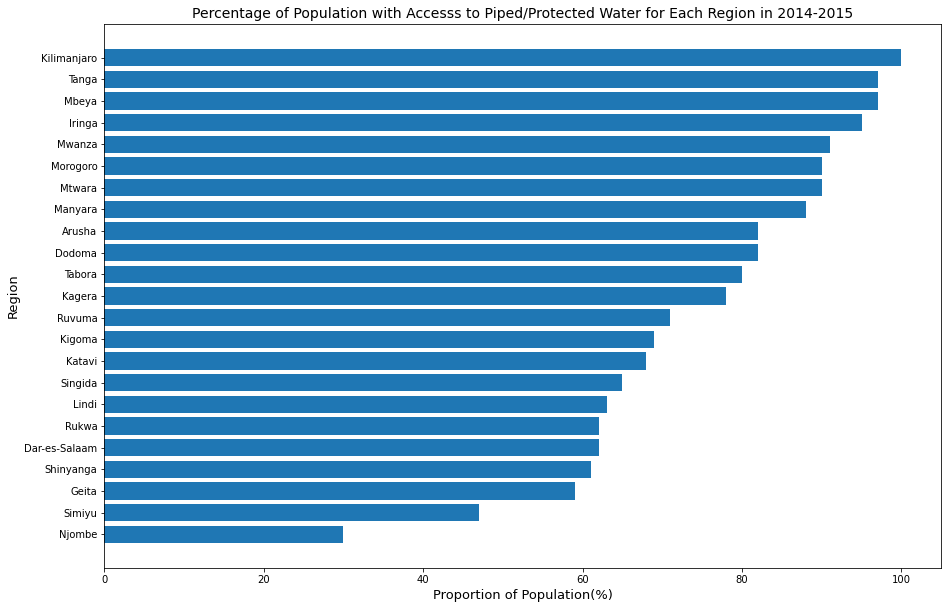

In [393]:
plt.figure(figsize=(15,10))
plt.barh(y = access_to_water_2014_by_region["Area"],
         width = access_to_water_2014_by_region["Data Value"])
plt.title("Percentage of Population with Accesss to Piped/Protected Water for Each Region in 2014-2015", fontsize=14)
plt.xlabel("Proportion of Population(%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

In [394]:
water_pop = water.loc['Population with access to piped or protected water as their main source in regional centres']\
    .sort_values(by='Time Period')
water_pop = water_pop.sort_values(by='Area')
water_pop.drop(columns='Footnotes', inplace=True)
water_pop = water_pop[water_pop['Area']!='Simiyu']  # filtering out regions not in water pump dataset
water_pop = water_pop[water_pop['Area']!='Njombe']
water_pop = water_pop[water_pop['Area']!='Katavi']
water_pop = water_pop[water_pop['Area']!='Geita']
water_pop.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Population with access to piped or protected water as their main source in regional centres,Percent,Total,Arusha,TZA001002,2010-2011,EWURA_Water Utilities Performance Review_Yearly,97.5
Population with access to piped or protected water as their main source in regional centres,Percent,Total,Arusha,TZA001002,2013-2014,EWURA_Water Utilities Performance Review_Yearly,82.0


In [395]:
water_pop_table = water_pop.pivot_table(values='Data Value', columns='Area', index='Time Period')
water_pop_table

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mbeya,Morogoro,Mtwara,Mwanza,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Time Period,,,,,,,,,,,,,,,,,,
2010-2011,97.5,88.7,96.0,71.1,67.0,95.3,41.0,68.4,95.0,94.0,81.7,93.4,62.8,81.0,77.5,88.0,86.5,92.0
2011-2012,70.4,86.7,84.0,71.1,68.7,95.3,41.0,68.5,96.2,94.0,92.5,90.0,61.6,87.8,78.3,89.5,86.5,98.4
2012-2013,78.0,81.0,96.0,76.0,71.0,100.0,70.0,84.0,97.0,90.0,88.0,94.0,62.0,64.0,59.0,62.0,77.0,99.0
2013-2014,82.0,81.0,96.0,76.0,68.0,100.0,58.0,88.0,97.0,90.0,81.0,96.0,62.0,69.0,59.0,62.0,79.0,99.0
2014-2015,82.0,82.0,95.0,78.0,69.0,100.0,63.0,88.0,97.0,90.0,90.0,91.0,62.0,71.0,61.0,65.0,80.0,97.0


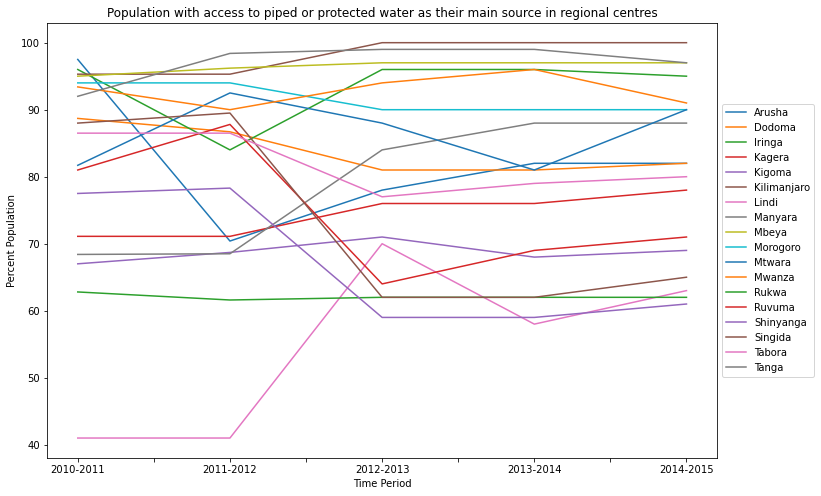

In [396]:
water_pop_table.plot(figsize=(12,8))
plt.title('Population with access to piped or protected water as their main source in regional centres')
plt.ylabel('Percent Population')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/access_to_piped_water.png', transparent=True, bbox_inches = 'tight');

- This is showing the percent of the population with access to piped or protected water as their main source. You can see how vastly different some of these regions are from each other and the inequality.

#### Households Within 1 km of Drinking Water in Dry Seasons

In [397]:
water_1km = water.loc['Households within 1 km of drinking water in dry seasons'].sort_values(by='Area')
water_1km = water_1km[water_1km['Subgroup']=='Total']  # filtering to just the subgroup 'total'
water_1km.drop(columns='Footnotes', inplace=True)
water_1km.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Households within 1 km of drinking water in dry seasons,Percent,Total,Arusha,TZA001002,2000-2001,NBS_Household Budget Survey (HBS) 2000-2001_2002,49.0
Households within 1 km of drinking water in dry seasons,Percent,Total,Dodoma,TZA001001,2000-2001,NBS_Household Budget Survey (HBS) 2000-2001_2002,49.0


In [398]:
water_1km_table = water_1km.pivot_table(values='Data Value', index='Area').sort_values(by='Data Value')
water_1km_table.head(2)

,Data Value
Area,
Mara,31.0
Mwanza,40.0


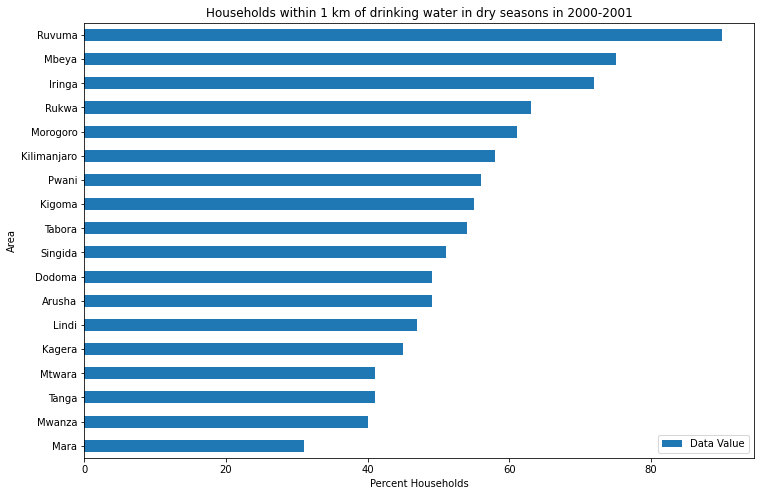

In [399]:
water_1km_table.plot(kind='barh', figsize=(12,8))
plt.title('Households within 1 km of drinking water in dry seasons in 2000-2001')
plt.xlabel('Percent Households')
plt.savefig('../visualizations/households_1km_from_water.png', transparent=True, bbox_inches = 'tight');

- This is showing the percent of households within 1 km of drinking water in dry seasons, organized from highest to lowest percentages. Ruvuma has the highest where Mara has the lowest.

#### Households Within 15 Minutes of Drinking Water in Dry Seasons

In [400]:
water_15min = water.loc['Households within 15 minutes to water supply in dry seasons'].sort_values(by='Area')
water_15min.drop(columns='Footnotes', inplace=True)
water_15min.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Households within 15 minutes to water supply in dry seasons,Percent,Total,Arusha,TZA001002,2000-2001,NBS_Household Budget Survey (HBS) 2000-2001_2002,65.8
Households within 15 minutes to water supply in dry seasons,Percent,Total,Dodoma,TZA001001,2000-2001,NBS_Household Budget Survey (HBS) 2000-2001_2002,71.3


In [401]:
water_15min_table = water_15min.pivot_table(values='Data Value', index='Area').sort_values(by='Data Value')
water_15min_table.head(2)

,Data Value
Area,
Mtwara,44.1
Mara,51.1


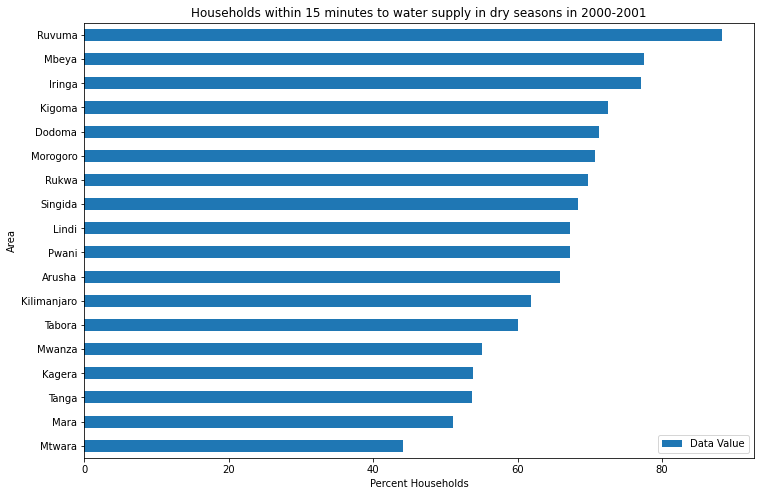

In [402]:
water_15min_table.plot(kind='barh', figsize=(12,8))
plt.title('Households within 15 minutes to water supply in dry seasons in 2000-2001')
plt.xlabel('Percent Households')
plt.savefig('../visualizations/households_15_min_from_water.png', transparent=True, bbox_inches = 'tight');

- This is showing the percentage of households within 15 minutes of a water supply in dry seasons. Here, Ruvuma is still the highest, but Mtwara is now the lowest.

#### Indicators Related to Health

In [403]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("diarrhoea")]

Children under-5 years with diarrhoea                                        220
Children under-5 years who drink more fluids during diarrhoea                 83
Children under-5 years who receive any ORT for diarrhoea                      60
Children under-5 years with diarrhoea taken to a health facility/provider     52
Children under-5 years who given ORS and zinc during diarrhoea                18
Name: Indicator, dtype: int64

> ORT = Oral Rehydration Therapy
>
> ORS = Oral Rehydration Solution

#### Children Under-5 Years with Diarrhoea

In [404]:
u5_diarrhoea = tanz["Indicator"] == "Children under-5 years with diarrhoea"
cols_to_drop = ["Indicator", "Unit", "Source", "Footnotes"]
u5_diarrhoea_df = tanz[u5_diarrhoea].drop(columns = cols_to_drop)
#Unit = Percent
u5_diarrhoea_df.head(3)

,Subgroup,Area,Area ID,Time Period,Data Value
4298,Female,Tanzania,TZA,2004-2005,11.7
4299,Female,Mainland,TZA001,2004-2005,11.7
4300,Female No education,Mainland,TZA001,2004-2005,13.1


In [405]:
u5_diarrhoea_df["Subgroup"].value_counts()
#will focus on the Total subgroup

Total                        160
Rural                         10
Urban                          9
Female                         7
Male                           7
Fourth wealth quintile         4
Highest wealth quintile        4
Lowest wealth quintile         4
Middle wealth quintile         4
Second wealth quintile         4
Female No education            2
Female Primary complete        2
Female Primary incomplete      2
Female Secondary               1
Name: Subgroup, dtype: int64

In [406]:
#focus on the subgroup Total
subgr_total = u5_diarrhoea_df["Subgroup"]=="Total"
u5_diarrhoea_df_total = u5_diarrhoea_df[subgr_total].drop(columns = ["Subgroup"])
u5_diarrhoea_df_total.sort_values(by = "Area").head(12)

,Area,Area ID,Time Period,Data Value
9936,Arusha,TZA001002,2010,12.6
8963,Arusha,TZA001002,1991-1992,23.3
7762,Arusha,TZA001002,2015-2016,9.2
9492,Arusha,TZA001002,1996,14.8
4319,Arusha,TZA001002,2004-2005,10.8
6133,Arusha,TZA001002,2010,12.6
6154,Dar-es-Salaam,TZA001007,2010,15.5
8978,Dar-es-Salaam,TZA001007,1991-1992,12.0
9507,Dar-es-Salaam,TZA001007,1996,10.0
4341,Dar-es-Salaam,TZA001007,2004-2005,7.4


In [407]:
u5_diarrhoea_df["Time Period"].value_counts()
#will focus on the newest time period 2015-2016

2010         74
2004-2005    46
2015-2016    41
1996         27
1991-1992    26
1999          6
Name: Time Period, dtype: int64

In [408]:
u5_diarrhoea_df["Area ID"].str.len().value_counts()
#will focus on regions. There Area ID length is 9

9    143
6     44
3     33
Name: Area ID, dtype: int64

In [409]:
subgr_total = u5_diarrhoea_df["Subgroup"]=="Total"
y2015 = u5_diarrhoea_df["Time Period"]=="2015-2016"
regions = u5_diarrhoea_df["Area ID"].str.len()==9

u5_diarrhoea_by_region_y2015 = u5_diarrhoea_df[subgr_total & y2015 & regions].drop(columns = "Subgroup")
u5_diarrhoea_by_region_y2015 = u5_diarrhoea_by_region_y2015.sort_values(by="Data Value")
u5_diarrhoea_by_region_y2015
#percentage of children under-5 that had diarrhoea in 2015-2016

,Area,Area ID,Time Period,Data Value
7775,Tabora,TZA001014,2015-2016,5.2
7764,Tanga,TZA001004,2015-2016,6.1
7788,Kusini Unguja,TZA002052,2015-2016,7.8
7772,Iringa,TZA001011,2015-2016,8.0
7765,Morogoro,TZA001005,2015-2016,8.5
7786,Geita,TZA001025,2015-2016,8.7
7762,Arusha,TZA001002,2015-2016,9.2
7789,Mjini Magharibi,TZA002053,2015-2016,9.3
7791,Kusini Pemba,TZA002055,2015-2016,9.5
7774,Singida,TZA001013,2015-2016,9.5


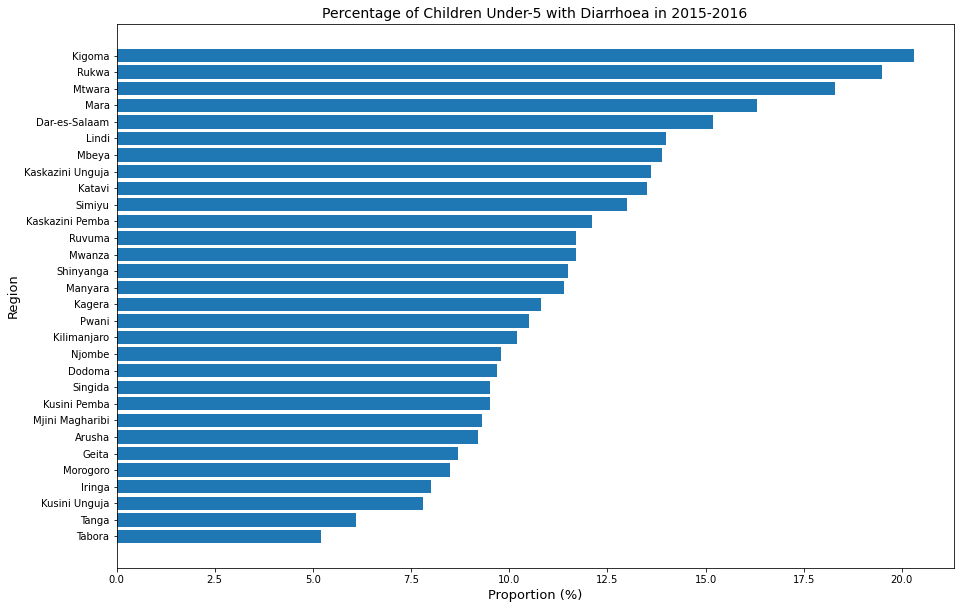

In [410]:
plt.figure(figsize=(15,10))
plt.barh(y = u5_diarrhoea_by_region_y2015["Area"],
         width = u5_diarrhoea_by_region_y2015["Data Value"])
# plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Percentage of Children Under-5 with Diarrhoea in 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

#### Children Under-5 Years Who Drink More Fluids During Diarrhoea

> What does drink more fluids mean? Does it mean they have access to more fluid (clean water)?

In [411]:
u5_more_fluid = tanz["Indicator"] == "Children under-5 years who drink more fluids during diarrhoea"
cols_to_drop = ["Indicator", "Unit", "Source", "Footnotes"]
u5_more_fluid_df = tanz[u5_more_fluid].drop(columns = cols_to_drop)
#Unit = Percent
u5_more_fluid_df.head(3)

,Subgroup,Area,Area ID,Time Period,Data Value
4288,Female,Tanzania,TZA,2004-2005,35.2
4289,Female,Mainland,TZA001,2004-2005,37.4
4952,Fourth wealth quintile,Mainland,TZA001,2004-2005,40.5


In [412]:
u5_more_fluid_df["Subgroup"].value_counts()

Total                      36
Rural                       8
Urban                       8
Female                      6
Male                        6
Fourth wealth quintile      3
Highest wealth quintile     3
Lowest wealth quintile      3
Middle wealth quintile      3
Second wealth quintile      3
No education                1
Primary complete            1
Primary incomplete          1
Secondary+                  1
Name: Subgroup, dtype: int64

In [413]:
#focus on the subgroup Total
subgr_total = u5_more_fluid_df["Subgroup"]=="Total"
u5_more_fluid_df_total = u5_more_fluid_df[subgr_total].drop(columns = ["Subgroup"])
u5_more_fluid_df_total.sort_values(by = "Area")

,Area,Area ID,Time Period,Data Value
9364,Arusha,TZA001002,1996,46.0
9355,Dar-es-Salaam,TZA001007,1996,73.0
9352,Dodoma,TZA001001,1996,58.0
9361,Iringa,TZA001011,1996,67.9
9345,Kagera,TZA001018,1996,57.7
9343,Kigoma,TZA001016,1996,68.3
9348,Kilimanjaro,TZA001003,1996,82.1
9356,Lindi,TZA001008,1996,66.3
9350,Mainland,TZA001,1996,66.9
9995,Mainland,TZA001,1999,31.7


In [414]:
u5_more_fluid_df_total["Area"].value_counts()

Tanzania         6
Mainland         5
Zanzibar         5
Dar-es-Salaam    1
Arusha           1
Singida          1
Mbeya            1
Iringa           1
Ruvuma           1
Shinyanga        1
Mtwara           1
Lindi            1
Morogoro         1
Pwani            1
Dodoma           1
Tanga            1
Kilimanjaro      1
Mara             1
Mwanza           1
Kagera           1
Kigoma           1
Rukwa            1
Tabora           1
Name: Area, dtype: int64

In [415]:
#mostly 1 data point (year = 1999) for each area
#Tanzania: 6 data points corresponding to 6 time periods 1991-92/1996/1999/2004-05/2010/2015-16
#mainland and Zanzibar: 5 data points, 5 time periods 1991-92/1996/1999/2004-05/2015-16

In [416]:
#let's map the Time Period to Year
#1991-1992 call it 1991
#2004-2005 call it 2004
#2015-2016 call it 2015

map_dict = {"1991-1992": 1991,
            "1996": 1996,
            "1999": 1999,
            "2004-2005": 2004,
            "2010": 2010,
            "2015-2016": 2015}
u5_more_fluid_df_total["Year"] = u5_more_fluid_df_total["Time Period"].map(map_dict)

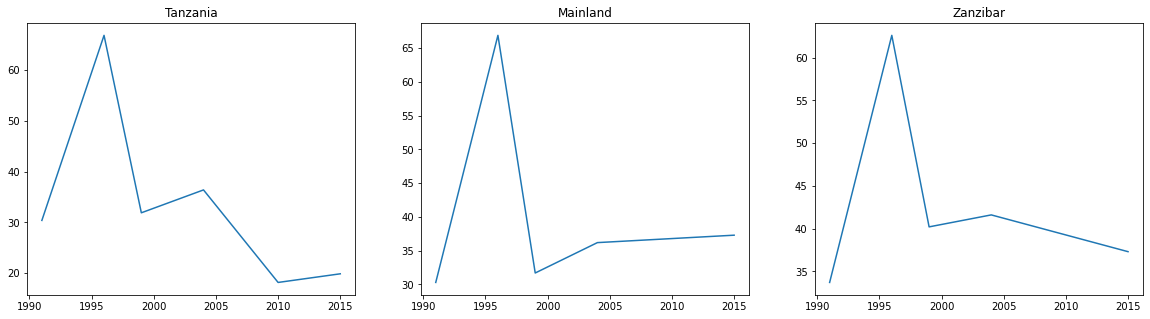

In [417]:
#plot Tanzania as a whole, mainland, and island (Zanzibar)
areas_to_plot = ["Tanzania", "Mainland", "Zanzibar"]

fig = plt.figure(figsize=(20,5))

for idx, area in enumerate(areas_to_plot):
    df = u5_more_fluid_df_total[u5_more_fluid_df_total["Area"] == area]
    df = df.sort_values(by = "Year")
    plt.subplot(1,3,idx+1)    
    plt.plot(df["Year"], df["Data Value"])
    plt.title(area)

> How can Tanzania go down to 20% for 2010 and 2015? They are >35% for Mainland and Zanzibar.

#### Children under-5 years stunted

In [418]:
u5_stunt = tanz["Indicator"] == "Children under-5 years stunted"
u5_stunt_df = tanz[u5_stunt]
u5_stunt_df.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4101,Children under-5 years stunted,Percent,Highest wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,15.7,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4102,Children under-5 years stunted,Percent,Lowest wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,44.9,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4103,Children under-5 years stunted,Percent,Male,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,38.6,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4104,Children under-5 years stunted,Percent,Middle wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,40.9,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4105,Children under-5 years stunted,Percent,No education,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,41.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [419]:
u5_stunt_df["Subgroup"].value_counts()

Total                      180
Rural                       18
Urban                       13
Male                         9
Other urban areas            9
Female                       9
No education                 5
Primary complete             5
Primary incomplete           5
Secondary+                   5
Highest wealth quintile      3
Lowest wealth quintile       3
Middle wealth quintile       3
Second wealth quintile       3
Fourth wealth quintile       3
Name: Subgroup, dtype: int64

In [420]:
#focus on subgroup = total
subgr_filter = u5_stunt_df["Subgroup"]=="Total"

In [421]:
u5_stunt_df["Area ID"].str.len().value_counts()

9    150
3     83
6     40
Name: Area ID, dtype: int64

In [422]:
#Area ID length of 9 are for the 30 regions
#focus on those
area_filter = u5_stunt_df["Area ID"].str.len()==9

In [423]:
u5_stunt_total_by_region = u5_stunt_df[subgr_filter & area_filter]
u5_stunt_total_by_region.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4117,Children under-5 years stunted,Percent,Total,Dodoma,TZA001001,2004-2005,NBS_ TDHS (2004-2005)_2005,44.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4118,Children under-5 years stunted,Percent,Total,Arusha,TZA001002,2004-2005,NBS_ TDHS (2004-2005)_2005,27.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4119,Children under-5 years stunted,Percent,Total,Kilimanjaro,TZA001003,2004-2005,NBS_ TDHS (2004-2005)_2005,23.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4120,Children under-5 years stunted,Percent,Total,Tanga,TZA001004,2004-2005,NBS_ TDHS (2004-2005)_2005,43.3,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4121,Children under-5 years stunted,Percent,Total,Morogoro,TZA001005,2004-2005,NBS_ TDHS (2004-2005)_2005,35.8,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [424]:
u5_stunt_total_by_region.drop(columns=["Indicator", "Unit", "Subgroup", "Source", "Footnotes"], inplace=True)
u5_stunt_total_by_region.head()

,Area,Area ID,Time Period,Data Value
4117,Dodoma,TZA001001,2004-2005,44.4
4118,Arusha,TZA001002,2004-2005,27.2
4119,Kilimanjaro,TZA001003,2004-2005,23.4
4120,Tanga,TZA001004,2004-2005,43.3
4121,Morogoro,TZA001005,2004-2005,35.8


In [425]:
u5_stunt_total_by_region["Time Period"].value_counts()
#30 means data available for all the regions

2015-2016    30
2014         30
2010         26
2004-2005    21
1991-1992    20
1996         20
2010-2011     1
2012-2013     1
2008-2009     1
Name: Time Period, dtype: int64

In [426]:
u5_stunt_total_by_region = u5_stunt_total_by_region.sort_values(by="Data Value")

In [427]:
u5_stunt_df[(u5_stunt_df["Subgroup"]=="Total") & (u5_stunt_df["Time Period"]=="2015-2016") & (u5_stunt_df["Area ID"]=="TZA")]
#national average for the year 2015-2016 is 34.4%

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
7664,Children under-5 years stunted,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,34.4,"TZA_ Demographic & Health Survey, 2015-2016, N..."


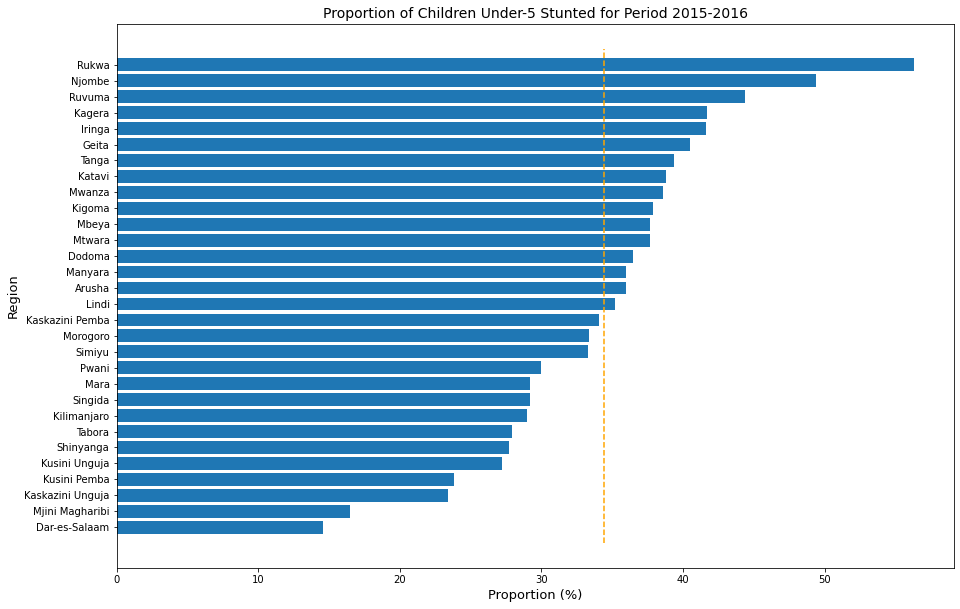

In [428]:
y1516 = u5_stunt_total_by_region["Time Period"]=="2015-2016"
plt.figure(figsize=(15,10))
plt.barh(y = u5_stunt_total_by_region.loc[y1516]["Area"],
         width = u5_stunt_total_by_region.loc[y1516]["Data Value"])
plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Proportion of Children Under-5 Stunted for Period 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

plt.savefig('../visualizations/Children_stunted_by_region', dpi=300, transparent=True, bbox_inches = 'tight');

> For the period 2015-2016, about 1/3 (34.4%) of the children under-5 nationalwide are stunted as indicated by the orange, dashed verticle line. The situation is worst for regions such as Rukwa and Njombe where every other children under-5 is stunted.

#### Children under-5 years wasted

In [429]:
u5_waste = tanz["Indicator"] == "Children under-5 years wasted"
u5_waste_df = tanz[u5_waste]
u5_waste_df.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4179,Children under-5 years wasted,Percent,Middle wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,2.5,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4180,Children under-5 years wasted,Percent,No education,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,3.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4181,Children under-5 years wasted,Percent,Other urban areas,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,2.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4182,Children under-5 years wasted,Percent,Other urban areas,Mainland,TZA001,2004-2005,NBS_ TDHS (2004-2005)_2005,2.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4183,Children under-5 years wasted,Percent,Primary complete,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,3.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [430]:
u5_waste_df["Subgroup"].value_counts()

Total                      180
Rural                       18
Urban                       12
Female                      10
Male                        10
Other urban areas            9
No education                 5
Primary complete             5
Primary incomplete           5
Secondary+                   5
Middle wealth quintile       3
Second wealth quintile       3
Fourth wealth quintile       3
Highest wealth quintile      3
Lowest wealth quintile       3
Name: Subgroup, dtype: int64

In [431]:
#focus on subgroup = total
subgr_filter = u5_waste_df["Subgroup"]=="Total"

In [432]:
u5_waste_df["Area ID"].str.len().value_counts()

9    150
3     85
6     39
Name: Area ID, dtype: int64

In [433]:
#Area ID length of 9 are for the 30 regions
#focus on those
area_filter = u5_waste_df["Area ID"].str.len()==9

In [434]:
u5_waste_total_by_region = u5_waste_df[subgr_filter & area_filter]
u5_waste_total_by_region.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4189,Children under-5 years wasted,Percent,Total,Ruvuma,TZA001010,2004-2005,NBS_ TDHS (2004-2005)_2005,0.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4190,Children under-5 years wasted,Percent,Total,Iringa,TZA001011,2004-2005,NBS_ TDHS (2004-2005)_2005,1.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4191,Children under-5 years wasted,Percent,Total,Mbeya,TZA001012,2004-2005,NBS_ TDHS (2004-2005)_2005,1.5,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4192,Children under-5 years wasted,Percent,Total,Singida,TZA001013,2004-2005,NBS_ TDHS (2004-2005)_2005,5.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4193,Children under-5 years wasted,Percent,Total,Arusha,TZA001002,2004-2005,NBS_ TDHS (2004-2005)_2005,3.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [435]:
u5_waste_total_by_region["Time Period"].value_counts()

2015-2016    30
2014         30
2010         26
2004-2005    21
1991-1992    20
1996         20
2010-2011     1
2012-2013     1
2008-2009     1
Name: Time Period, dtype: int64

In [436]:
u5_waste_total_by_region = u5_waste_total_by_region.sort_values(by="Data Value")

In [437]:
u5_waste_df[(u5_waste_df["Subgroup"]=="Total") & (u5_waste_df["Time Period"]=="2015-2016") & (u5_waste_df["Area ID"]=="TZA")]
#national average for the year 2015-2016 is 4.5%

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
7683,Children under-5 years wasted,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,4.5,"TZA_ Demographic & Health Survey, 2015-2016, N..."


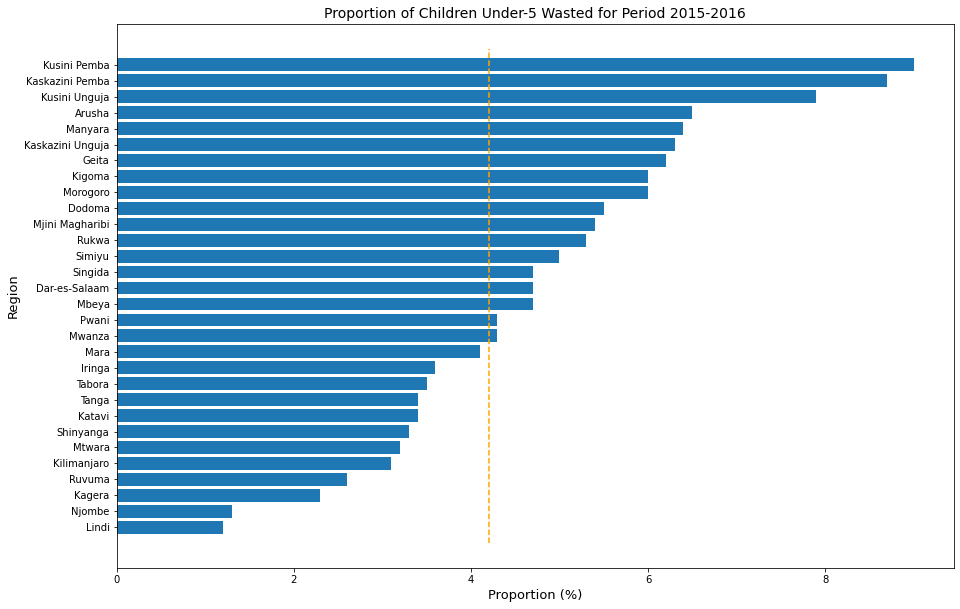

In [438]:
y1516 = u5_waste_total_by_region["Time Period"]=="2015-2016"
plt.figure(figsize=(15,10))
plt.barh(y = u5_waste_total_by_region.loc[y1516]["Area"],
         width = u5_waste_total_by_region.loc[y1516]["Data Value"])
plt.vlines(x=4.2, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Proportion of Children Under-5 Wasted for Period 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

> For the period 2015-2016, 4.2% of the children under-5 nationalwide are wasted as indicated by the orange, dashed verticle line. The situation is worst for regions such as Kusini Pemba, Kaskazini Pemba, Kusini Unguja where about 8% children under-5 is wasted.
>
> The situation with stunting seems much worst. Maybe we should focus on stunting only.

#### Any Other Indicators of Interest

> Population: size, growth rate, density?

In [439]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("population")][:25]

Population size                                                                                1801
Population 15-49 years who know that a healthy looking person can have AIDS                     207
Population 15-49 years who have been tested for HIV                                             178
Population 15-49 years who have had 2 or more sex partners in the past 12 months                168
Population 15-49 years who believe a female HIV positive teacher should be allowed to teach     164
Population annual growth rate                                                                   149
Population density                                                                              145
Population 15-49 years circumcised                                                              140
Projected population size                                                                       130
Population with access to piped or protected water as their main source in regional centres     128


In [440]:
pop_size = tanz["Indicator"]=="Population size"
subgr_total = tanz["Subgroup"]=="Total"
year2012 = tanz["Time Period"]=="2012"

cols_to_drop = ["Indicator", "Unit", "Subgroup", "Time Period", "Source", "Footnotes"]
pop_df = tanz[(pop_size) & (subgr_total) & (year2012)].drop(columns=cols_to_drop)
pop_df.head()

,Area,Area ID,Data Value
55658,Hai,TZA001003005,210533.0
55659,Moshi Manispaa,TZA001003006,184292.0
55660,Siha,TZA001003007,116313.0
55661,Tanga,TZA001004,2045205.0
55662,Lushoto,TZA001004001,492441.0


In [441]:
pop_df["Area ID"].str.len().value_counts()

12    169
9      30
6       2
3       1
Name: Area ID, dtype: int64

>The shorter Area ID, the bigger the region
>
>Area ID = TZA is Tanzania as a whole
>
>It then breaks down into Mainland (TZA001) and Zanzibar (TZA002)
>
>Mainland and Zanzibar further break down into smaller areas
>
>Area ID TZA001xxx belongs to Mainland, Area ID TZA002xxx belongs to Zanzibar (island)

In [442]:
pop_df[pop_df["Area ID"].str.len()==3]
#country as a whole

,Area,Area ID,Data Value
55712,Tanzania,TZA,44928923.0


In [443]:
pop_df[pop_df["Area ID"].str.len()==6]
#country = Mainland + Zanzibar (island)

,Area,Area ID,Data Value
55713,Mainland,TZA001,43625354.0
55870,Zanzibar,TZA002,1303569.0


In [444]:
pop_by_area_df = pop_df[pop_df["Area ID"].str.len()==9].sort_values(by = "Area ID")
pop_by_area_df
#Mainland = 25 smaller regions
#Zanzibar = 5 smaller regions
#The population by region might be useful

,Area,Area ID,Data Value
55714,Dodoma,TZA001001,2083588.0
55722,Arusha,TZA001002,1694310.0
55730,Kilimanjaro,TZA001003,1640087.0
55661,Tanga,TZA001004,2045205.0
55736,Morogoro,TZA001005,2218492.0
55744,Pwani,TZA001006,1098668.0
55760,Dar-es-Salaam,TZA001007,4364541.0
55710,Lindi,TZA001008,864652.0
55769,Mtwara,TZA001009,1270854.0
55777,Ruvuma,TZA001010,1376891.0


In [445]:
pop_by_area_df["Data Value"].sum()

44928923.0

In [446]:
pop_df[pop_df["Area"]=="Tanzania"]

,Area,Area ID,Data Value
55712,Tanzania,TZA,44928923.0


### Separating out columns pertaining to inequality/socioeconomic from census data

In [447]:
socioecon = pd.read_csv('../data/cleaned_data/tz_regions_socioecon.csv', index_col='Indicator')
socioecon.drop(columns=['Footnotes', 'Unnamed: 0'], inplace=True)

In [448]:
socioecon = socioecon[socioecon['Area']!='Simiyu']
socioecon = socioecon[socioecon['Area']!='Njombe']  #filtering out regions not in water pump dataset
socioecon = socioecon[socioecon['Area']!='Katavi']
socioecon = socioecon[socioecon['Area']!='Geita']

In [449]:
socioecon = socioecon[socioecon['Time Period'] > '1999']  # filtering to more recent years

In [450]:
socioecon.T.columns.value_counts()

GDP per capita (at current prices)                                         258
Health worker density per 10,000 population- (Clinicians=MO,AMO and CO)     60
Health worker density per 10,000 population-nurse and midwife               60
Human development index                                                     57
Health insurance coverage age 15-49                                         40
Name: Indicator, dtype: int64

#### GDP Per Capita

In [451]:
gdp = socioecon.loc['GDP per capita (at current prices)'].sort_values(by='Time Period')
gdp['USD'] = gdp['Data Value'] * 0.00043  # converting tanzanian shillings to USD for comparison
gdp.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,USD
Indicator,,,,,,,,
GDP per capita (at current prices),Tshs,Total,Iringa,TZA001011,2000,MoFEA_Economic Survey (ES)_Yearly,217041.07,93.327660
GDP per capita (at current prices),Tshs,Total,Shinyanga,TZA001017,2000,MoFEA_Economic Survey (ES)_Yearly,231554.70,99.568521


In [452]:
gdp_table = gdp.pivot_table(values='USD', columns='Area', index='Time Period', fill_value=0)

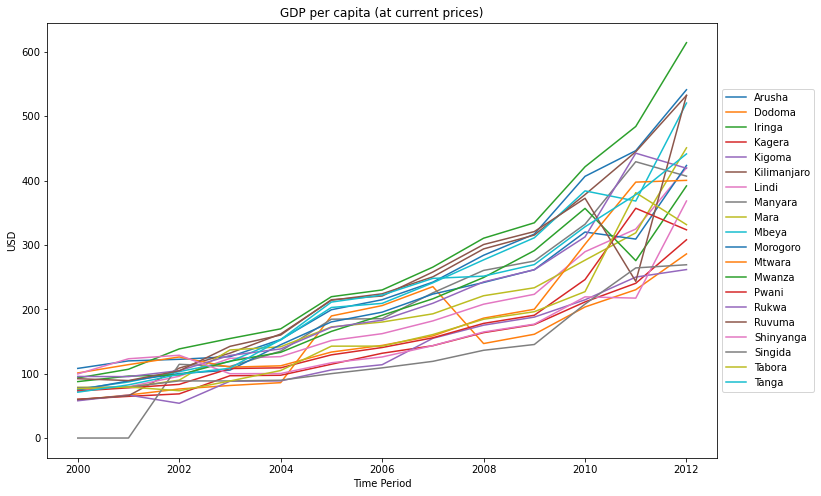

In [453]:
gdp_table.plot(figsize=(12,8))
plt.title('GDP per capita (at current prices)')
plt.ylabel('USD')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/gpd_per_capita.png', transparent=True, bbox_inches = 'tight'); 

- This is showing the GDP per capita over the years. You can see the general trend of all regions increasing.

#### Health Worker (Clinician) Density

In [454]:
health_worker_clinician = socioecon.loc['Health worker density per 10,000 population- (Clinicians=MO,AMO and CO)']\
            .sort_values(by='Time Period')
health_worker_clinician.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
"Health worker density per 10,000 population- (Clinicians=MO,AMO and CO)",Ratio,Total,Lindi,TZA001008,2011,MoHSW_HRIS Annual Report_Yearly,0.77
"Health worker density per 10,000 population- (Clinicians=MO,AMO and CO)",Ratio,Total,Tanga,TZA001004,2011,MoHSW_HRIS Annual Report_Yearly,0.75


In [455]:
health_worker_clinician_table = health_worker_clinician.pivot_table(
    values='Data Value', columns='Area', index='Time Period'
)

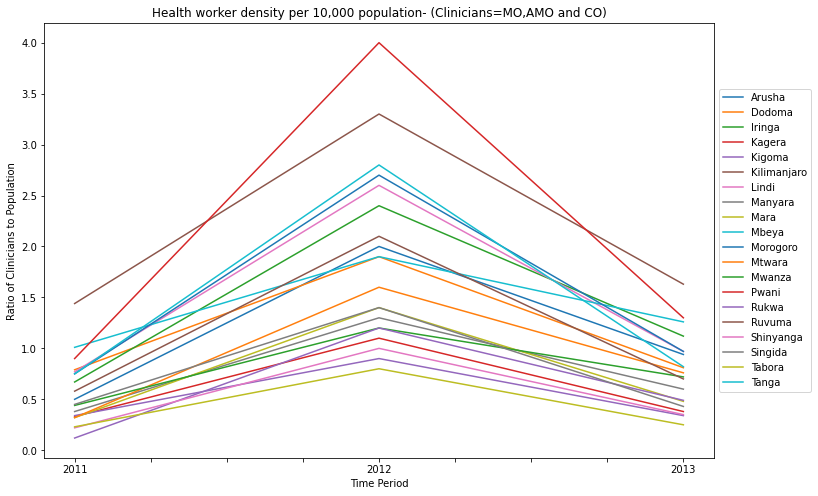

In [456]:
health_worker_clinician_table.plot(figsize=(12,8))
plt.title('Health worker density per 10,000 population- (Clinicians=MO,AMO and CO)')
plt.ylabel('Ratio of Clinicians to Population')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/clinician_density.png', transparent=True, bbox_inches = 'tight');  # look into types of clinicians

- This is showing the healthcare clinician density per 10,000 people. This is referring to Medical Officers (MO), Assistant Medical Officer (AMO), and Clinical Officer (CO). There is a distinct trend for all regions where the amount of healthcare clinicians increased in 2012 and then decreases again in 2013.

#### Health Worker (Nurse/Midwife) Density

In [457]:
health_worker_nurse = socioecon.loc['Health worker density per 10,000 population-nurse and midwife']\
        .sort_values(by='Time Period')
health_worker_nurse.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
"Health worker density per 10,000 population-nurse and midwife",Ratio,Total,Kagera,TZA001018,2011,MoHSW_HRIS Annual Report_Yearly,1.8
"Health worker density per 10,000 population-nurse and midwife",Ratio,Total,Arusha,TZA001002,2011,MoHSW_HRIS Annual Report_Yearly,3.4


In [458]:
health_worker_nurse_table = health_worker_nurse.pivot_table(
    values='Data Value', columns='Area', index='Time Period'
)

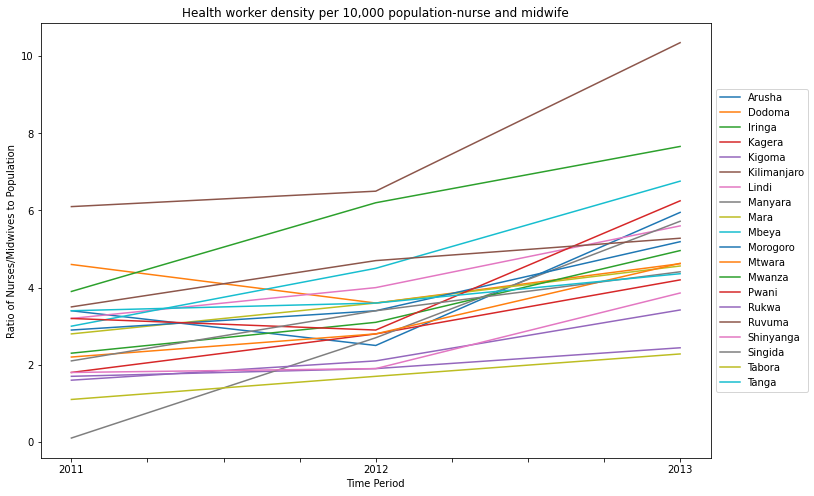

In [459]:
health_worker_nurse_table.plot(figsize=(12,8))
plt.title('Health worker density per 10,000 population-nurse and midwife')
plt.ylabel('Ratio of Nurses/Midwives to Population')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/nurse_density.png', transparent=True, bbox_inches = 'tight');

- This is showing the amount of nurses and midwives per 10,000 people. This pattern isn't as extreme as the clinicians, but it does show a steady increase for most regions over the years.

#### Health Development Index

In [460]:
human_dev = socioecon.loc['Human development index'].sort_values(by='Area')
human_dev.head(3)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Human development index,Percent,Female,Arusha,TZA001002,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.677
Human development index,Percent,Male,Arusha,TZA001002,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.761
Human development index,Percent,Total,Arusha,TZA001002,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.721


In [461]:
human_dev_table = human_dev.pivot_table(values='Data Value', columns='Area', index='Subgroup')

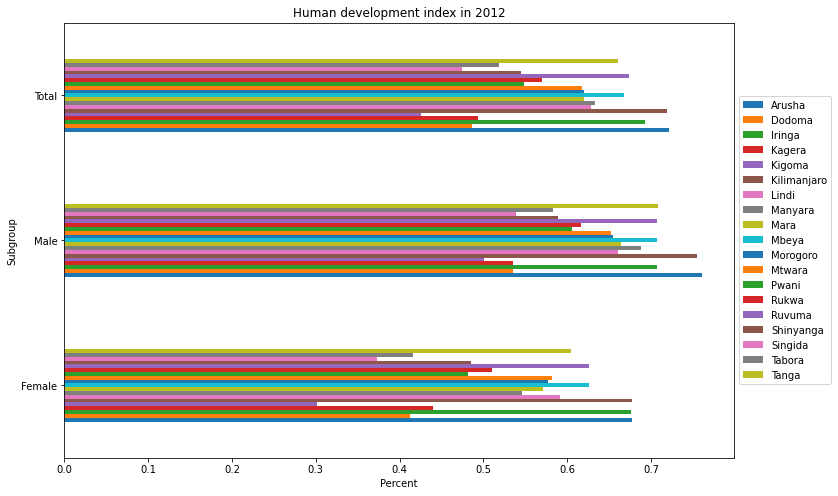

In [462]:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot-in-matplotlib

human_dev_table.plot(figsize=(12,8), kind='barh')
plt.title('Human development index in 2012')
plt.xlabel('Percent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));   # remove total??

- This is showing the percentage of the human development index for male, female, and total population for the regions. The overall trend is that males seem to have a higher percentage than females.

In [463]:
human_dev_no_total = socioecon.loc['Human development index'].sort_values(by='Area')
human_dev_no_total = human_dev_no_total[human_dev_no_total['Subgroup']!='Total'] # filtered out the total subgroup
human_dev_no_total.head(3)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Human development index,Percent,Female,Arusha,TZA001002,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.677
Human development index,Percent,Male,Arusha,TZA001002,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.761
Human development index,Percent,Female,Dodoma,TZA001001,2012,NBS/MoFP_Tanzania Human Development Report_2014,0.413


In [464]:
human_dev_no_total_table = human_dev_no_total.pivot_table(values='Data Value', columns='Area', index='Subgroup')
human_dev_no_total_table

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Subgroup,,,,,,,,,,,,,,,,,,,
Female,0.677,0.413,0.676,0.440,0.301,0.678,0.591,0.546,0.571,0.626,0.577,0.582,0.482,0.510,0.626,0.485,0.373,0.416,0.605
Male,0.761,0.536,0.707,0.536,0.501,0.755,0.661,0.688,0.664,0.707,0.655,0.652,0.606,0.617,0.707,0.589,0.539,0.583,0.708


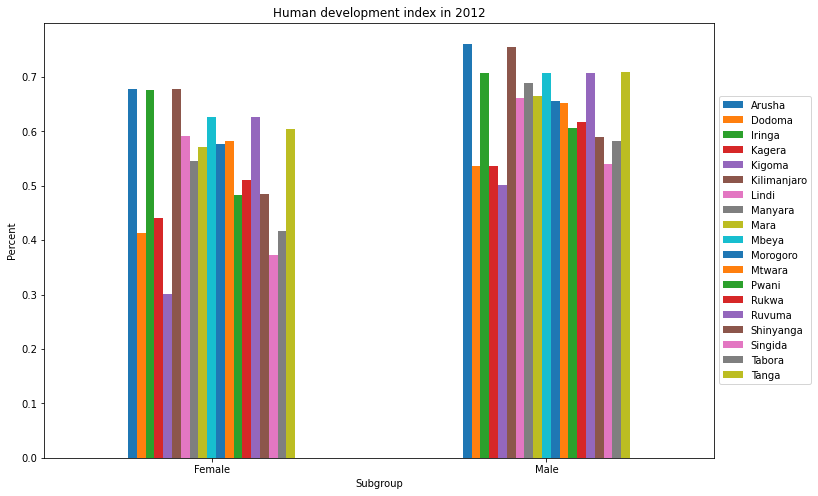

In [465]:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot-in-matplotlib

human_dev_no_total_table.plot(figsize=(12,8), kind='bar')
plt.title('Human development index in 2012')
plt.ylabel('Percent')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/human_development.png', transparent=True, bbox_inches = 'tight');

- This is the same graph as above, but without the total. It's easier to see the difference between the males and females per subregion here.

#### Health Insurance Coverage

In [466]:
health_insur = socioecon.loc['Health insurance coverage age 15-49'].sort_values(by='Area')
health_insur.head(2)

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value
Indicator,,,,,,,
Health insurance coverage age 15-49,Percent,Female,Arusha,TZA001002,2015-2016,NBS_ TDHS (2015-2016)_2016,0.6
Health insurance coverage age 15-49,Percent,Male,Arusha,TZA001002,2015-2016,NBS_ TDHS (2015-2016)_2016,3.2


In [467]:
health_insur_table = health_insur.pivot_table(values='Data Value', columns='Area', index='Subgroup')
health_insur_table

Area,Arusha,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
Subgroup,,,,,,,,,,,,,,,,,,,,
Female,0.6,4.9,0.7,0.7,1.7,3.7,3.2,0.3,0.2,0.0,1.7,1.4,1.9,3.2,1.1,0.7,3.6,2.9,2.9,1.7
Male,3.2,0.0,0.0,5.8,2.5,4.9,2.1,0.0,0.0,0.7,0.0,4.4,0.0,1.1,0.7,0.0,0.0,2.5,0.0,1.6


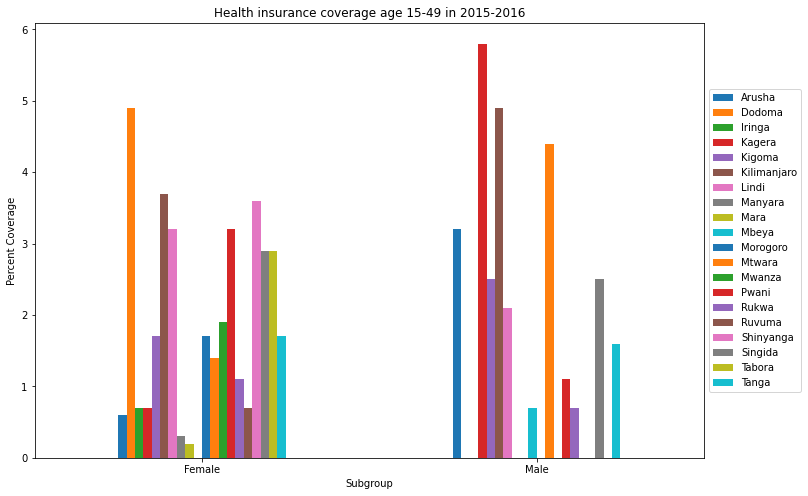

In [468]:
health_insur_table.plot(figsize=(12,8), kind='bar')
plt.title('Health insurance coverage age 15-49 in 2015-2016')
plt.ylabel('Percent Coverage')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../visualizations/health_insurance coverage.png', transparent=True, bbox_inches = 'tight');

- This is showing the difference in health insurance coverage for the regions. Some regions only had coverage for females, one had coverage for males only, and some were just so distinctly different between the males and females in the regions that did have coverage for both. It's interesting how different it is for each region.

In [469]:
census = pd.read_csv('../data/Tanzania_2012_en.csv', index_col='Indicator').T

In [470]:
census_rural = census.T[census.T['Subgroup']=='Rural']
census_rural = census_rural[census_rural['Area']!='Mainland']
census_rural = census_rural[census_rural['Area']!='Tanzania']
census_rural = census_rural[census_rural['Area']!='Simiyu']  # filtering out regions not in water pump dataset
census_rural = census_rural[census_rural['Area']!='Njombe']
census_rural = census_rural[census_rural['Area']!='Katavi']
census_rural = census_rural[census_rural['Area']!='Geita']
census_rural = census_rural[census_rural['Time Period']>'1999']  # filtering to more recent years
census_rural.head()

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2008,EWURA_Water Utilities Performance Review_Yearly,68.8,NaN
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2009,EWURA_Water Utilities Performance Review_Yearly,69.09,NaN
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2010,EWURA_Water Utilities Performance Review_Yearly,68.89,NaN
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2011,EWURA_Water Utilities Performance Review_Yearly,73.07,NaN
Water coverage,Percent,Rural,Kilimanjaro,TZA001003,2012,EWURA_Water Utilities Performance Review_Yearly,74.444593,NaN


In [471]:
census_urban = census.T[census.T['Subgroup']=='Urban']

In [472]:
census.columns.unique()

Index(['Children under-5 years severely underweight', 'Production of cement',
       'Primary school net enrolment ratio', 'Armed robbery',
       'Cases of child theft', 'Cases of breaking', 'Cases of child desertion',
       'Death cause by road accidents', 'Robbery with violence',
       'Theft of arms',
       ...
       'Facilities with urine dipstick for glucose diagnostics in ANC section',
       'Facilities with urine dipstick for protein diagnostics in ANC section',
       'Annual turnover', 'Broadcasting stations',
       'Ease of doing business (global ranking)',
       'Easy of dealing with construction permits',
       'Children aged 0-17 years both living in multidimensional poverty and below the national basic needs poverty line',
       'Children aged 0-17 years living in multidimensional poverty (having at least 3 deprivations)',
       'Children aged 0-17 years living below the national basic needs poverty line',
       'Women members of parliament'],
      dtype='obj

In [473]:
safe_water_dry = census['Households with access to safe drinking water during the dry season'].T\
    [census['Households with access to safe drinking water during the dry season'].T['Area']=='Tanzania']
safe_water_dry = safe_water_dry[safe_water_dry['Subgroup']!='Total'] # filtering out the rural and urban areas of Tanzania
safe_water_dry

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Households with access to safe drinking water during the dry season,Percent,Rural,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",39.8,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the dry season,Percent,Urban,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",73.5,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the dry season,Percent,Rural,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",41.6,"TZA_Tanzania National Panel Survey (NPS), 2012..."
Households with access to safe drinking water during the dry season,Percent,Urban,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",77.7,"TZA_Tanzania National Panel Survey (NPS), 2012..."


In [474]:
safe_water_dry_table = safe_water_dry.pivot_table(values='Data Value', columns='Subgroup', index='Time Period')
safe_water_dry_table

Subgroup,Rural,Urban
Time Period,,
2010-2011,39.8,73.5
2012-2013,41.6,77.7


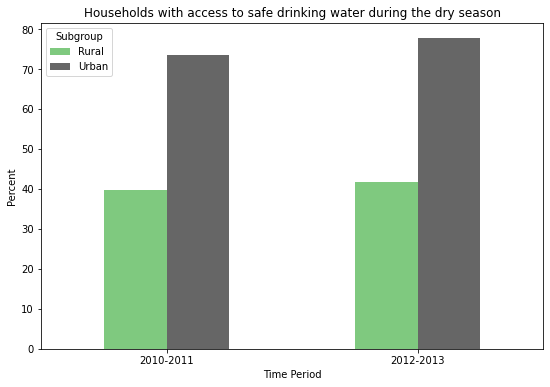

In [475]:
safe_water_dry_table.plot(kind='bar', figsize=(9,6), cmap='Accent')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.title('Households with access to safe drinking water during the dry season')
plt.savefig('../visualizations/access_to_safe_water_dry_season.png', transparent=True, bbox_inches = 'tight');

In [476]:
safe_water_rainy = census['Households with access to safe drinking water during the rainy season'].T\
    [census['Households with access to safe drinking water during the rainy season'].T['Area']=='Tanzania']
safe_water_rainy = safe_water_rainy[safe_water_rainy['Subgroup']!='Total']
safe_water_rainy

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Households with access to safe drinking water during the rainy season,Percent,Rural,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",32.3,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the rainy season,Percent,Urban,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",66.4,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the rainy season,Percent,Rural,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",35.4,"TZA_Tanzania National Panel Survey (NPS), 2012..."
Households with access to safe drinking water during the rainy season,Percent,Urban,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",69.1,"TZA_Tanzania National Panel Survey (NPS), 2012..."


In [477]:
safe_water_rainy_table = safe_water_rainy.pivot_table(values='Data Value', columns='Subgroup', index='Time Period')
safe_water_rainy_table

Subgroup,Rural,Urban
Time Period,,
2010-2011,32.3,66.4
2012-2013,35.4,69.1


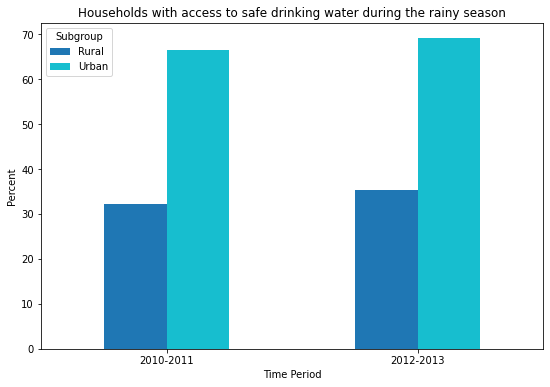

In [478]:
safe_water_rainy_table.plot(kind='bar', figsize=(9,6), cmap='tab10')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.title('Households with access to safe drinking water during the rainy season')
plt.savefig('../visualizations/access_to_safe_water_rainy_season.png', transparent=True, bbox_inches = 'tight');

In [479]:
safe_water_access = pd.concat([safe_water_dry, safe_water_rainy])
safe_water_access  # trying to combine dfs to make one bar chart

,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
Indicator,,,,,,,,
Households with access to safe drinking water during the dry season,Percent,Rural,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",39.8,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the dry season,Percent,Urban,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",73.5,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the dry season,Percent,Rural,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",41.6,"TZA_Tanzania National Panel Survey (NPS), 2012..."
Households with access to safe drinking water during the dry season,Percent,Urban,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",77.7,"TZA_Tanzania National Panel Survey (NPS), 2012..."
Households with access to safe drinking water during the rainy season,Percent,Rural,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",32.3,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the rainy season,Percent,Urban,Tanzania,TZA,2010-2011,"NBS_Tanzania National Panel Survey (NPS), 2010...",66.4,"TZA_Tanzania National Panel Survey (NPS), 2010..."
Households with access to safe drinking water during the rainy season,Percent,Rural,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",35.4,"TZA_Tanzania National Panel Survey (NPS), 2012..."
Households with access to safe drinking water during the rainy season,Percent,Urban,Tanzania,TZA,2012-2013,"NBS_Tanzania National Panel Survey (NPS), 2012...",69.1,"TZA_Tanzania National Panel Survey (NPS), 2012..."


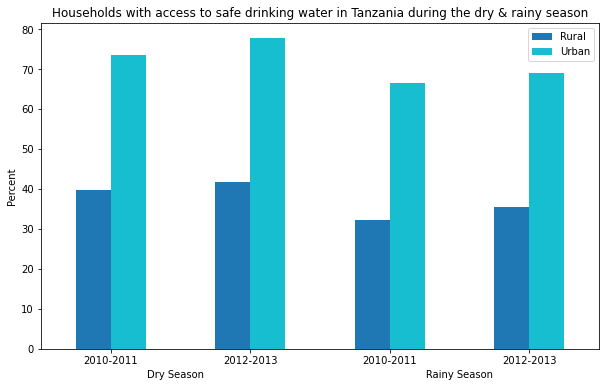

In [480]:
pd.concat([safe_water_dry_table, safe_water_rainy_table]).plot(kind='bar', figsize=(10,6), cmap='tab10')
plt.xticks(rotation=0)  # combined both into one chart for easier interpretation
plt.ylabel('Percent')
plt.xlabel('Dry Season                                                                       Rainy Season')
plt.title('Households with access to safe drinking water in Tanzania during the dry & rainy season')
plt.legend(loc='upper right')
plt.savefig('../visualizations/access_to_water_combined.png', transparent=True, bbox_inches = 'tight');